In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold #Cross-Validation
from sklearn.metrics import mean_squared_error #MSE Error
import lightgbm as lgb #Light Gradient Bossting Model
from gc import collect # Garbage Collection
from sklearn.preprocessing import LabelEncoder #Encoder for Categorical Features
from sklearn.model_selection import train_test_split #Split the dataset into Train and Validation
from sklearn.metrics import r2_score #R2 Metric
import matplotlib.pyplot as plt
%matplotlib inline
collect()

4

In [2]:
#Taken from Kaggle Kernels
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object or df[col].dtype != 'datetime64':  # Exclude strings and Datetimes           
            # Print current column type
            #print("******************************")
            #print("Column: ",col)
            #print("dtype before: ",df[col].dtype)            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            #print("min for this col: ",mn)
            #print("max for this col: ",mx)
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else: 
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            #print("dtype after: ",df[col].dtype)
            #print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [3]:
weather_train_csv = pd.read_csv(r"D:\Narendra\ASHRAE ENERGY PREDICTOR/weather_train.csv")
weather_test_csv = pd.read_csv(r"D:\Narendra\ASHRAE ENERGY PREDICTOR/weather_test.csv")

In [4]:
weather_train_csv["newtimestamp"] = pd.to_datetime(weather_train_csv["timestamp"])
weather_train_csv["hour"] = weather_train_csv["newtimestamp"].dt.hour.astype(int)
weather_train_csv["day"] = weather_train_csv["newtimestamp"].dt.day.astype(int)
weather_train_csv["weekend"] = weather_train_csv["newtimestamp"].dt.weekday.astype(int)
weather_train_csv["month"] = weather_train_csv["newtimestamp"].dt.month.astype(int)
weather_train_csv["year"] = weather_train_csv["newtimestamp"].dt.year.astype(int)
weather_train_csv.drop('newtimestamp', axis=1, inplace=True)

weather_test_csv["newtimestamp"] = pd.to_datetime(weather_test_csv["timestamp"])
weather_test_csv["hour"] = weather_test_csv["newtimestamp"].dt.hour.astype(int)
weather_test_csv["day"] = weather_test_csv["newtimestamp"].dt.day.astype(int)
weather_test_csv["weekend"] = weather_test_csv["newtimestamp"].dt.weekday.astype(int)
weather_test_csv["month"] = weather_test_csv["newtimestamp"].dt.month.astype(int)
weather_test_csv["year"] = weather_test_csv["newtimestamp"].dt.year.astype(int)
weather_test_csv.drop('newtimestamp', axis=1, inplace=True)

In [5]:
#weather_train_csv['Season'] = 
def get_season(month, day):
    if month in (1, 2, 3):
        season = 1
    elif month in (4, 5, 6):
        season = 2
    elif month in (7, 8, 9):
        season = 3
    else:
        season = 4

    if (month == 3) and (day > 19):
        season = 2
    elif (month == 6) and (day > 20):
        season = 3
    elif (month == 7) and (day > 21):
        season = 4
    elif (month == 12) and (day > 20):
        season = 1
    return season


In [6]:
season = []
for day, month in zip(weather_train_csv["month"], weather_train_csv["day"]):
    season.append(get_season(month, day))
weather_train_csv['season'] = season
season = []
for day, month in zip(weather_test_csv["month"], weather_test_csv["day"]):
    season.append(get_season(month, day))
weather_test_csv['season'] = season

In [7]:
#Preprocessing (Fillina NaN values with mean value)
for col in weather_train_csv.columns[weather_train_csv.isna().any()]:
    #print(col)
    weather_train_csv[col] = weather_train_csv.groupby(['site_id', 'year', 'month', 'day'])[col].apply(lambda x: x.fillna(x.median()))
    weather_train_csv[col] = weather_train_csv[col].fillna(weather_train_csv[col].mean())
    weather_test_csv[col] = weather_test_csv.groupby(['site_id', 'year', 'month', 'day'])[col].apply(lambda x: x.fillna(x.median()))
    weather_test_csv[col] = weather_test_csv[col].fillna(weather_test_csv[col].mean())

D:\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [8]:
temp = weather_train_csv['timestamp']
weather_train_csv, NAList = reduce_mem_usage(weather_train_csv.drop('timestamp', axis=1))
weather_train_csv['timestamp'] = temp
temp = weather_test_csv['timestamp']
weather_test_csv, NAList = reduce_mem_usage(weather_test_csv.drop('timestamp', axis=1))
weather_test_csv['timestamp'] = temp

Memory usage of properties dataframe is : 12.263530731201172  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  4.532251358032227  MB
This is  36.95714926942828 % of the initial size
Memory usage of properties dataframe is : 24.324878692626953  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  8.989706039428711  MB
This is  36.95683811222276 % of the initial size


In [9]:
collect()
train_csv = pd.read_csv(r"D:\Narendra\ASHRAE ENERGY PREDICTOR/train.csv")
building_meta_data_csv = pd.read_csv(r"D:\Narendra\ASHRAE ENERGY PREDICTOR/building_metadata.csv")

In [10]:
train_csv = train_csv.merge(building_meta_data_csv, on = 'building_id')
train_csv = train_csv.merge(weather_train_csv, on = ['site_id', 'timestamp'])

In [11]:
test_csv = pd.read_csv(r"D:\Narendra\ASHRAE ENERGY PREDICTOR/test.csv")
test_csv = test_csv.merge(building_meta_data_csv, on = 'building_id')
test_csv = test_csv.merge(weather_test_csv, on = ['site_id', 'timestamp'])

In [12]:
del weather_test_csv, weather_train_csv, building_meta_data_csv
collect()

20

In [13]:
le = LabelEncoder()
train_csv["primary_use"] = le.fit_transform(train_csv["primary_use"])
train_csv["primary_use"] = train_csv["primary_use"].astype(int)
train_csv['square_feet'] = np.log(train_csv['square_feet'])

test_csv["primary_use"] = le.transform(test_csv["primary_use"])
test_csv["primary_use"] = test_csv["primary_use"].astype(int)
test_csv['square_feet'] = np.log(test_csv['square_feet'])

In [14]:
holidays = [(2016, 1, 1), (2016, 1, 18), (2016, 2, 15), (2016, 5, 30), (2016, 7, 4), (2016, 9, 5), (2016, 10, 10), (2016, 11, 11), (2016, 11, 24), 
            (2016, 12, 25), (2016, 12, 26),
            (2017, 1, 1), (2017, 1, 2), (2017, 1, 16), (2017, 2, 20), (2017, 5, 29), (2017, 7, 4), (2017, 9, 4), (2017, 10, 9), (2017, 11, 10), 
            (2017, 11, 11), (2017, 11, 23), (2017, 12, 25),
            (2018, 1, 1), (2018, 1, 15), (2018, 2, 19), (2018, 5, 28), (2018, 7, 4), (2018, 9, 3), (2018, 10, 8), (2018, 11, 11), (2018, 11, 12), 
            (2018, 11, 22), (2018, 12, 25),
            (2019, 1, 1), (2019, 1, 21), (2019, 2, 18), (2019, 5, 27), (2019, 7, 4), (2019, 9, 2), (2019, 10, 14), (2019, 11, 11), (2019, 11, 28), 
            (2019, 12, 25),
            (2020, 1, 1), (2020, 1, 20), (2020, 2, 17), (2020, 5, 25), (2020, 7, 3), (2020, 7, 4), (2020, 9, 7), (2020, 10, 12), (2020, 11, 11), 
            (2020, 11, 26), (2020, 12, 25)]
train_csv['isHoliday'] = 0
test_csv['isHoliday'] = 0

for item in holidays:
    train_csv.loc[(train_csv['day']==item[2]) & (train_csv['month']==item[1]) & (train_csv['year']==item[0]), 'isHoliday'] = 1
    test_csv.loc[(test_csv['day']==item[2]) & (test_csv['month']==item[1]) & (test_csv['year']==item[0]), 'isHoliday'] = 1
train_csv.drop(columns=['year', 'day'], inplace=True)
test_csv.drop(columns=['timestamp', 'year', 'day'], inplace=True)

train_csv['meter_reading'] = np.log1p(train_csv['meter_reading'])
collect()

0

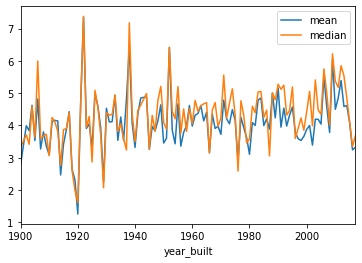

In [15]:
train_csv.groupby('year_built')['meter_reading'].agg(['mean', 'median']).plot(kind='bar')

In [16]:
train_csv['timestamp'] = pd.to_datetime(train_csv['timestamp'])
train_csv.set_index('timestamp', inplace=True)
train_csv.columns

Index(['building_id', 'meter', 'meter_reading', 'site_id', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'hour', 'weekend',
       'month', 'season', 'isHoliday'],
      dtype='object')

In [17]:
building_df = train_csv.groupby(['building_id'])['meter_reading'].agg(['mean', 'median'])
building_df.reset_index(inplace=True)
building_df.columns = ['building_id', 'building_mean', 'building_median']
site_df = train_csv.groupby(['site_id'])['meter_reading'].agg(['mean', 'median'])
site_df.reset_index(inplace=True)
site_df.columns = ['site_id', 'site_mean', 'site_median']
primary_use_df = train_csv.groupby(['primary_use'])['meter_reading'].agg(['mean', 'median'])
primary_use_df.reset_index(inplace=True)
primary_use_df.columns = ['primary_use', 'primary_use_mean', 'primary_use_median']
year_built_df = train_csv.groupby(['year_built'])['meter_reading'].agg(['mean', 'median'])
year_built_df.reset_index(inplace=True)
year_built_df.columns = ['year_built', 'year_built_mean', 'year_built_median']

In [18]:
train_csv = train_csv.merge(building_df, on = 'building_id')
train_csv = train_csv.merge(site_df, on = 'site_id')
train_csv = train_csv.merge(primary_use_df, on = 'primary_use')
train_csv = train_csv.merge(year_built_df, on = 'year_built')
train_csv.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,season,isHoliday,building_mean,building_median,site_mean,site_median,primary_use_mean,primary_use_median,year_built_mean,year_built_median
0,0,0,0.0,0,0,8.91355,2008.0,NaN,25.000000,6.0,...,1,1,3.356302,5.250974,3.777701,4.836639,4.376656,4.679814,3.782392,4.010119
1,0,0,0.0,0,0,8.91355,2008.0,NaN,24.400000,6.0,...,1,1,3.356302,5.250974,3.777701,4.836639,4.376656,4.679814,3.782392,4.010119
2,0,0,0.0,0,0,8.91355,2008.0,NaN,22.799999,2.0,...,1,1,3.356302,5.250974,3.777701,4.836639,4.376656,4.679814,3.782392,4.010119
3,0,0,0.0,0,0,8.91355,2008.0,NaN,21.100000,2.0,...,1,1,3.356302,5.250974,3.777701,4.836639,4.376656,4.679814,3.782392,4.010119
4,0,0,0.0,0,0,8.91355,2008.0,NaN,20.000000,2.0,...,1,1,3.356302,5.250974,3.777701,4.836639,4.376656,4.679814,3.782392,4.010119


In [19]:
test_csv = test_csv.merge(building_df, on = 'building_id')
test_csv = test_csv.merge(site_df, on = 'site_id')
test_csv = test_csv.merge(primary_use_df, on = 'primary_use')
test_csv = test_csv.merge(year_built_df, on = 'year_built')
test_csv.head()

,row_id,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,season,isHoliday,building_mean,building_median,site_mean,site_median,primary_use_mean,primary_use_median,year_built_mean,year_built_median
0,0,0,0,0,0,8.91355,2008.0,NaN,17.799999,4.0,...,1,1,3.356302,5.250974,3.777701,4.836639,4.376656,4.679814,3.782392,4.010119
1,129,0,0,0,0,8.91355,2008.0,NaN,17.799999,2.0,...,1,1,3.356302,5.250974,3.777701,4.836639,4.376656,4.679814,3.782392,4.010119
2,258,0,0,0,0,8.91355,2008.0,NaN,16.100000,0.0,...,1,1,3.356302,5.250974,3.777701,4.836639,4.376656,4.679814,3.782392,4.010119
3,387,0,0,0,0,8.91355,2008.0,NaN,17.200001,0.0,...,1,1,3.356302,5.250974,3.777701,4.836639,4.376656,4.679814,3.782392,4.010119
4,516,0,0,0,0,8.91355,2008.0,NaN,16.700001,2.0,...,1,1,3.356302,5.250974,3.777701,4.836639,4.376656,4.679814,3.782392,4.010119


In [20]:
categoricals = ["hour", "season", "weekend", "month", "meter", "isHoliday"]
sparse_columns = [col for col in train_csv.columns if (col not in categoricals and col != 'meter_reading')]

In [21]:
for col in ['building_id', 'site_id', 'primary_use', 'year_built']:
    sparse_columns.remove(col)
sparse_columns

['square_feet',
 'floor_count',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed',
 'building_mean',
 'building_median',
 'site_mean',
 'site_median',
 'primary_use_mean',
 'primary_use_median',
 'year_built_mean',
 'year_built_median']

In [22]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler().fit(train_csv[sparse_columns])
train_csv[sparse_columns] = scale.transform(train_csv[sparse_columns])
test_csv[sparse_columns] = scale.transform(test_csv[sparse_columns])

In [23]:
test_csv['floor_count'] = test_csv['floor_count'].fillna(-1)
test_csv.isna().sum()

row_id                0
building_id           0
meter                 0
site_id               0
primary_use           0
square_feet           0
year_built            0
floor_count           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
hour                  0
weekend               0
month                 0
season                0
isHoliday             0
building_mean         0
building_median       0
site_mean             0
site_median           0
primary_use_mean      0
primary_use_median    0
year_built_mean       0
year_built_median     0
dtype: int64

In [24]:
collect()
train_csv, NAList = reduce_mem_usage(train_csv)
test_csv, NAList = reduce_mem_usage(test_csv)

Memory usage of properties dataframe is : 1528.224754333496  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  702.9833869934082  MB
This is  46.0 % of the initial size
Memory usage of properties dataframe is : 3233.5208892822266  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1487.4196090698242  MB
This is  46.0 % of the initial size


In [25]:
X, test_x, Y, test_y = train_test_split(train_csv[categoricals+sparse_columns], train_csv['meter_reading'], test_size = 0.25)

In [26]:
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor()
dt_reg

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [27]:
from sklearn.model_selection import cross_val_score
res = cross_val_score(dt_reg, X, Y, cv=10)
res

array([0.94706386, 0.9456671 , 0.94642006, 0.94612932, 0.94674028,
       0.9471214 , 0.94609392, 0.9479644 , 0.94604701, 0.94570512])

In [28]:
dt_reg.fit(X, Y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [29]:
dt_reg.score(test_x, test_y)

0.9481639248457586

In [30]:
predictions = np.expm1(dt_reg.predict(test_x))
print(r2_score(predictions, np.expm1(test_y)))

0.9616660764198923


In [31]:
test_pred = np.expm1(dt_reg.predict(test_csv[categoricals+sparse_columns]))
test_pred = np.where(test_pred<0, 0, test_pred)

In [32]:
test_pred = pd.DataFrame(np.vstack((test_csv['row_id'], test_pred)).T, columns = ['row_id', 'meter_reading'])

In [33]:
submission = pd.read_csv(r"D:\Narendra\ASHRAE ENERGY PREDICTOR/sample_submission.csv")

In [34]:
submission = submission.merge(test_pred, on='row_id', how = 'left')

In [35]:
submission.drop('meter_reading_x', axis=1, inplace=True)
submission.rename(columns={'meter_reading_y':'meter_reading'}, inplace=True)

In [36]:
submission.isna().sum(), submission.shape, test_csv.shape

(row_id                  0
 meter_reading    24744638
 dtype: int64, (41697600, 2), (16952962, 28))

In [37]:
submission['meter_reading'] = submission['meter_reading'].fillna(0)

In [38]:
submission.to_csv(r"D:\Narendra\ASHRAE ENERGY PREDICTOR/submission_dt.csv", index=False)
submission.shape

(41697600, 2)

In [39]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse', 'mae', 'r2'},
            'subsample': 0.5,
            'learning_rate': 0.35,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.9,
            'num_leaves': 2048,
            'max_depth': 10,
            'max_bin' : 256
            }

lgb_train = lgb.Dataset(X, Y, categorical_feature=categoricals)
lgb_eval = lgb.Dataset(test_x, test_y, categorical_feature=categoricals)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=(lgb_train, lgb_eval),
               early_stopping_rounds=200,
               verbose_eval = 200)
    

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds
[200]	training's l1: 0.209902	training's rmse: 0.395689	valid_1's l1: 0.223735	valid_1's rmse: 0.43492
[400]	training's l1: 0.185971	training's rmse: 0.34826	valid_1's l1: 0.20919	valid_1's rmse: 0.413816
[600]	training's l1: 0.172518	training's rmse: 0.318377	valid_1's l1: 0.203415	valid_1's rmse: 0.405145
[800]	training's l1: 0.162404	training's rmse: 0.295688	valid_1's l1: 0.199895	valid_1's rmse: 0.399932
[1000]	training's l1: 0.154763	training's rmse: 0.278336	valid_1's l1: 0.198103	valid_1's rmse: 0.397321
[1200]	training's l1: 0.147951	training's rmse: 0.263225	valid_1's l1: 0.196561	valid_1's rmse: 0.395293
[1400]	training's l1: 0.142048	training's rmse: 0.249896	valid_1's l1: 0.195495	valid_1's rmse: 0.393763
[1600]	training's l1: 0.136797	training's rmse: 0.238375	valid_1's l1: 0.194805	valid_1's rmse: 0.392755
[1800]	training's l1: 0.132143	training's rmse: 0.22829	valid_1's l1: 0.194298	valid_1's rmse: 0.392044
[

In [40]:
predictions = np.expm1(gbm.predict(test_x))
print(r2_score(predictions, np.expm1(test_y)))

0.8758610579366447


In [41]:
from sklearn.externals import joblib
# save model
joblib.dump(gbm, r"D:\Narendra\ASHRAE ENERGY PREDICTOR/lgb_v3.pkl")

D:\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['D:\\Narendra\\ASHRAE ENERGY PREDICTOR/lgb_v3.pkl']

In [43]:
predictions = np.expm1(gbm.predict(test_x))
print(r2_score(predictions, np.expm1(test_y)))

KeyboardInterrupt: 

In [ ]:
del train_csv
collect()
m = test_csv.shape
print(m)

In [ ]:
test_pred = np.array([])
i=0
for j in range(1000000,m[0], 1000000):
    #print(i)
    if i==0:
        test_pred = np.expm1(gbm.predict(test_csv.loc[i:j-1, X.columns]))
    else:
        #print(ndarray.shape, new_pred[i].shape)
        test_pred = np.vstack((test_pred, np.expm1(gbm.predict(test_csv.loc[i:j-1, X.columns]))))
    i=j
    print(i, test_pred.shape)
print(test_pred.shape)
print(j, len(test_pred))

In [ ]:
test_pred = test_pred.flatten()
test_pred = np.append(test_pred, np.expm1(gbm.predict(test_csv.loc[j:, X.columns])))

In [ ]:
test_pred = np.where(test_pred<0,0,test_pred)

In [ ]:
test_pred = pd.DataFrame(np.vstack((test_csv['row_id'], test_pred)).T, columns = ['row_id', 'meter_reading'])

In [ ]:
submission = pd.read_csv(r"D:\Narendra\ASHRAE ENERGY PREDICTOR/sample_submission.csv")

In [ ]:
submission = submission.merge(test_pred, on='row_id', how = 'left')

In [ ]:
submission.drop('meter_reading_x', axis=1, inplace=True)
submission.rename(columns={'meter_reading_y':'meter_reading'}, inplace=True)

In [ ]:
submission.isna().sum(), submission.shape, test_csv.shape

In [ ]:
submission['meter_reading'] = submission['meter_reading'].fillna(0)

In [ ]:
submission.to_csv(r"D:\Narendra\ASHRAE ENERGY PREDICTOR/submission.csv", index=False)